In [1]:
import pandas as pd
import seaborn as sb
import matplotlib as plt
import numpy as np
import sklearn
import matplotlib.pyplot as mtplt
from nltk.corpus import stopwords
from collections import  Counter
from sklearn.feature_extraction.text import CountVectorizer
import gensim
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.tokenize import word_tokenize
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
from wordcloud import WordCloud, STOPWORDS
pyLDAvis.enable_notebook()

C:\Users\Aishwarya Singh\anaconda3\lib\site-packages\sklearn\decomposition\_lda.py:28: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  EPS = np.finfo(np.float).eps


In [2]:
tweetData = pd.read_csv('text_emotion_recognition_updated.csv', index_col=False)
tweetData

tweet_id                                              tweet  tweettype
0             0  @ZubairSabirPTI  pls dont insult the word 'Molna'      anger
1             1  @ArcticFantasy I would have almost took offens...      anger
2             2  @IllinoisLoyalty that Rutgers game was an abom...      anger
3             3  @CozanGaming that's what lisa asked before she...      anger
4             4  Sometimes I get mad over something so minuscul...      anger
...         ...                                                ...        ...
43955     43955                                   @JohnLloydTaylor    neutral
43956     43956                     Happy Mothers Day  All my love       love
43957     43957  Happy Mother's Day to all the mommies out ther...       love
43958     43958  @niariley WASSUP BEAUTIFUL!!! FOLLOW ME!!  PEE...  happiness
43959     43959  @mopedronin bullet train from tokyo    the gf ...       love

[43960 rows x 3 columns]

#### Number of characters present in each sentence. This can give us a rough idea about the tweet length

<AxesSubplot:>

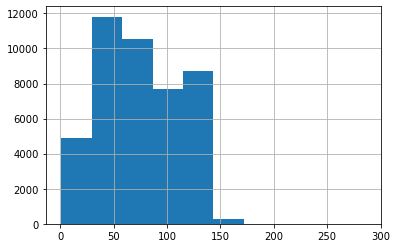

In [4]:
tweetData['tweet'].str.len().hist()

#### Plot the number of words appearing in each tweet

<AxesSubplot:>

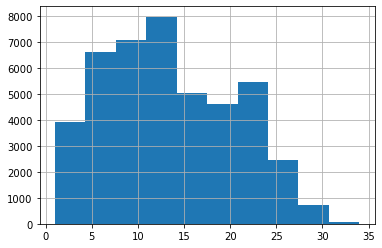

In [5]:
tweetData['tweet'].str.split().\
    map(lambda x: len(x)).\
    hist()

#### Check the average word length in each sentence

<AxesSubplot:>

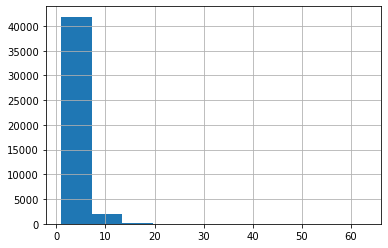

In [6]:
tweetData['tweet'].str.split().\
   apply(lambda x : [len(i) for i in x]). \
   map(lambda x: np.mean(x)).hist()

#### Does this mean that people are using really short words in tweets? One reason why this may not be true is stopwords. Stopwords are the words that are most commonly used in any language such as the, a, an, etc. As these words are small in length these words may have caused the above graph to be left-skewed.

In [7]:
import nltk
stop=set(stopwords.words('english'))

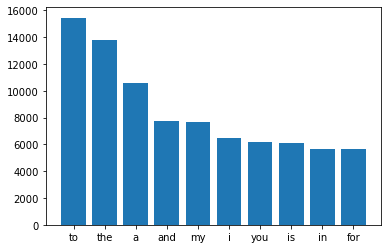

In [8]:
corpus=[]
check= tweetData['tweet'].str.split()
check=check.values.tolist()
corpus=[word for i in check for word in i]

from collections import defaultdict
dic=defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word]+=1
        
top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 
x,y=zip(*top)
mtplt.bar(x,y)
mtplt.show()

#### Now we know which stopwords occur frequently in our text. Next step - inspect which words other than these stopwords occur frequently. Use collections library function

<AxesSubplot:>

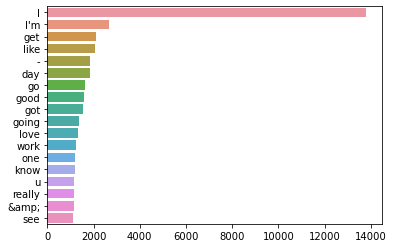

In [9]:
counter=Counter(corpus)
most=counter.most_common()

x, y= [], []
for word,count in most[:60]:
    if (word not in stop):
        x.append(word)
        y.append(count)
        
sb.barplot(x=y,y=x)

#### Since these are tweets (poor grammar) it will include some stopwords as well. Next, N-gram analysis - N-grams are simply contiguous sequences of n words. Looking at most frequent n-grams can give you a better understanding of the context in which the word was used. To build a representation of the vocabulary - Countvectorizer. Countvectorizer is a simple method used to tokenize, vectorize and represent the corpus in an appropriate form. A function that combines everything above.

In [10]:
def plot_top_ngrams_barchart(text, n=2):
    stop=set(stopwords.words('english'))

    new= text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]

    def _get_top_ngram(corpus, n=None):
        vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
        bag_of_words = vec.transform(corpus)
        sum_words = bag_of_words.sum(axis=0) 
        words_freq = [(word, sum_words[0, idx]) 
                      for word, idx in vec.vocabulary_.items()]
        words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
        return words_freq[:10]

    top_n_bigrams=_get_top_ngram(text,n)[:10]
    x,y=map(list,zip(*top_n_bigrams))
    sb.barplot(x=y,y=x)

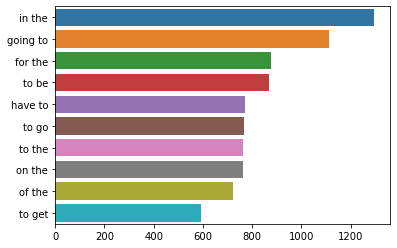

In [11]:
plot_top_ngrams_barchart(tweetData['tweet'],2)

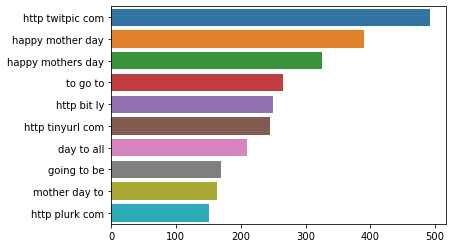

In [12]:
plot_top_ngrams_barchart(tweetData['tweet'],3)

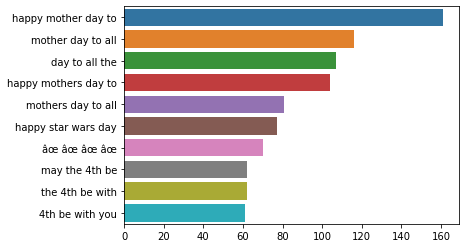

In [13]:
plot_top_ngrams_barchart(tweetData['tweet'],4)

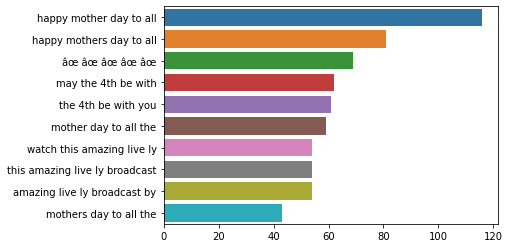

In [14]:
plot_top_ngrams_barchart(tweetData['tweet'],5)

#### Topic modeling is the process of using unsupervised learning techniques to extract the main topics that occur in a collection of documents. Latent Dirichlet Allocation (LDA) is an easy to use and efficient model for topic modeling. Each document is represented by the distribution of topics and each topic is represented by the distribution of words. 

#### - tokenize: the process by which sentences are converted to a list of tokens or words.
#### - remove stopwords
#### - lemmatize: reduces the inflectional forms of each word into a common base or root.
#### - convert to the bag of words: Bag of words is a dictionary where the keys are words(or ngrams/tokens) and values are the number of times each word occurs in the corpus.

In [15]:
def get_lda_objects(text):
    nltk.download('stopwords')
    nltk.download('punkt')
    nltk.download('wordnet')
    stop=set(stopwords.words('english'))

    
    def _preprocess_text(text):
        corpus=[]
        stem=PorterStemmer()
        lem=WordNetLemmatizer()
        for news in text:
            words=[w for w in word_tokenize(news) if (w not in stop)]

            words=[lem.lemmatize(w) for w in words if len(w)>2]

            corpus.append(words)
        return corpus
    
    corpus=_preprocess_text(text)
    
    dic=gensim.corpora.Dictionary(corpus)
    bow_corpus = [dic.doc2bow(doc) for doc in corpus]
    
    lda_model =  gensim.models.LdaMulticore(bow_corpus, 
                                   num_topics = 10, 
                                   id2word = dic,                                    
                                   passes = 10,
                                   workers = 2)
    
    return lda_model, bow_corpus, dic

def plot_lda_vis(lda_model, bow_corpus, dic):
    vis = gensimvis.prepare(lda_model, bow_corpus, dic)
    return vis

In [16]:
lda_model, bow_corpus, dic = get_lda_objects(tweetData['tweet'])

[nltk_data] Downloading package stopwords to C:\Users\Aishwarya
[nltk_data]     Singh\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package punkt to C:\Users\Aishwarya
[nltk_data]     Singh\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Aishwarya
[nltk_data]     Singh\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [17]:
lda_model.show_topics()

[(0,
  '0.068*"http" + 0.012*"You" + 0.010*"good" + 0.010*"welcome" + 0.007*"luck" + 0.006*"The" + 0.006*"\'re" + 0.006*"hehe" + 0.005*"New" + 0.005*"life"'),
 (1,
  '0.033*"like" + 0.024*"..." + 0.019*"one" + 0.016*"feel" + 0.014*"better" + 0.014*"good" + 0.013*"n\'t" + 0.011*"really" + 0.011*"last" + 0.010*"look"'),
 (2,
  '0.012*"...." + 0.012*"back" + 0.011*"time" + 0.010*"..." + 0.009*"could" + 0.007*"school" + 0.007*"late" + 0.007*"amp" + 0.007*"bit" + 0.006*"wish"'),
 (3,
  '0.031*"work" + 0.027*"..." + 0.023*"home" + 0.018*"got" + 0.010*"get" + 0.010*"back" + 0.008*"today" + 0.008*"Just" + 0.008*"n\'t" + 0.008*"hour"'),
 (4,
  '0.044*"Day" + 0.044*"Happy" + 0.028*"Mother" + 0.015*"Mothers" + 0.011*"http" + 0.009*"mom" + 0.008*"DAY" + 0.008*"love" + 0.008*"..." + 0.008*"rain"'),
 (5,
  '0.025*"thanks" + 0.021*"Thanks" + 0.015*"..." + 0.011*"watching" + 0.010*"follow" + 0.008*"party" + 0.007*"good" + 0.007*"got" + 0.007*"love" + 0.007*"book"'),
 (6,
  '0.071*"day" + 0.023*"mother

In [18]:
plot_lda_vis(lda_model, bow_corpus, dic)

C:\Users\Aishwarya Singh\AppData\Roaming\Python\Python38\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
9      0.155353 -0.127311       1        1  17.130212
1      0.127147 -0.055345       2        1  14.017018
6      0.108139  0.239120       3        1  11.756020
7      0.051180 -0.101273       4        1  11.520652
3      0.081818  0.001981       5        1  11.423353
2      0.061719  0.077334       6        1   9.427302
5      0.004693 -0.023990       7        1   8.178797
0     -0.181034 -0.055076       8        1   6.081149
4     -0.170903  0.029128       9        1   5.785534
8     -0.238112  0.015434      10        1   4.679963, topic_info=           Term         Freq        Total Category  logprob  loglift
222         day  3094.000000  3094.000000  Default  30.0000  30.0000
11723      quot  2233.000000  2233.000000  Default  29.0000  29.0000
11692      http  2225.000000  2225.000000  Default  28.0000  28.0000
726        know  1545.000000  1545.000000  Default  27.0000  27.0000
1540      Happy  1051.000000  1051.000000  Default  26.0000  26.0000
...         ...          ...          ...      ...      ...      ...
859    happened    45.256125    85.190293  Topic10  -5.8975   2.4293
1003       suck    51.085455   283.432777  Topic10  -5.7763   1.3484
3990       send    46.033428   129.255477  Topic10  -5.8805   2.0295
102        much    54.230849  1006.484543  Topic10  -5.7166   0.1409
94         love    53.051947  1918.960231  Topic10  -5.7386  -0.5264

[650 rows x 6 columns], token_table=       Topic      Freq     Term
term                           
109        1  0.884021      'll
109        3  0.002447      'll
109        4  0.053009      'll
109        5  0.046484      'll
109        6  0.013048      'll
...      ...       ...      ...
2458       8  0.043550      yet
2307       2  0.951924  youtube
2307       3  0.045876  youtube
23834      7  0.978892      yum
13106      1  0.986975      ï¿½

[1359 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[10, 2, 7, 8, 4, 3, 6, 1, 5, 9])

#### Wordcloud is a great way to represent text data. The size and color of each word that appears in the wordcloud indicate it’s frequency or importance.

In [19]:
def plot_wordcloud(text):
    nltk.download('stopwords')
    stop=set(stopwords.words('english'))

    def _preprocess_text(text):
        corpus=[]
        stem=PorterStemmer()
        lem=WordNetLemmatizer()
        for news in text:
            words=[w for w in word_tokenize(news) if (w not in stop)]

            words=[lem.lemmatize(w) for w in words if len(w)>2]

            corpus.append(words)
        return corpus
    
    corpus=_preprocess_text(text)
    
    wordcloud = WordCloud(
        background_color='white',
        stopwords=set(STOPWORDS),
        max_words=100,
        max_font_size=30, 
        scale=3,
        random_state=1)
    
    wordcloud=wordcloud.generate(str(corpus))

    fig = mtplt.figure(1, figsize=(12, 12))
    mtplt.axis('off')
 
    mtplt.imshow(wordcloud)
    mtplt.show()

[nltk_data] Downloading package stopwords to C:\Users\Aishwarya
[nltk_data]     Singh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


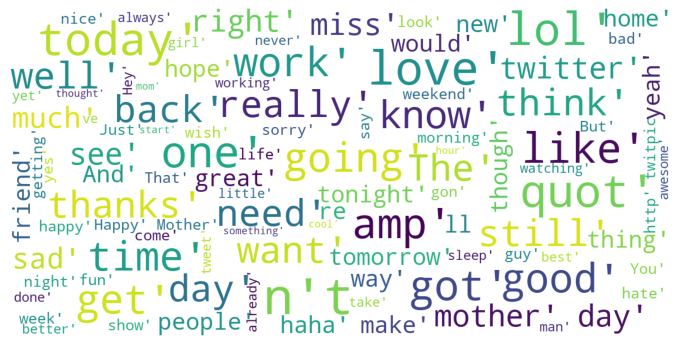

In [20]:
plot_wordcloud(tweetData['tweet'])

neutral       8638
worry         8459
sadness       6025
happiness     5209
love          3842
surprise      2187
fun           1776
relief        1526
hate          1323
fear          1257
anger         1051
joy            902
empty          827
enthusiasm     759
boredom        179
Name: tweettype, dtype: int64


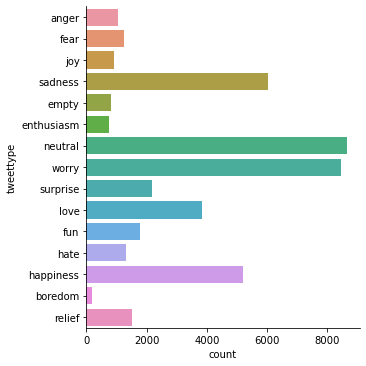

In [21]:
print(tweetData["tweettype"].value_counts())
sb.catplot(y = "tweettype", data = tweetData, kind = "count")

In [22]:
tweetData.set_index('tweet_id')

tweet  tweettype
tweet_id                                                              
0         @ZubairSabirPTI  pls dont insult the word 'Molna'      anger
1         @ArcticFantasy I would have almost took offens...      anger
2         @IllinoisLoyalty that Rutgers game was an abom...      anger
3         @CozanGaming that's what lisa asked before she...      anger
4         Sometimes I get mad over something so minuscul...      anger
...                                                     ...        ...
43955                                      @JohnLloydTaylor    neutral
43956                        Happy Mothers Day  All my love       love
43957     Happy Mother's Day to all the mommies out ther...       love
43958     @niariley WASSUP BEAUTIFUL!!! FOLLOW ME!!  PEE...  happiness
43959     @mopedronin bullet train from tokyo    the gf ...       love

[43960 rows x 2 columns]

In [24]:
tweetData.index.name = 'index'

In [25]:
tweetData = tweetData.set_index('tweet_id')

In [26]:
tweetData.loc[tweetData['tweettype'] == 'hate', 'tweettype'] = 'anger'
tweetData.loc[tweetData['tweettype'] == 'happiness', 'tweettype'] = 'joy'
tweetData.loc[tweetData['tweettype'] == 'fun', 'tweettype'] = 'enthusiasm'
tweetData.loc[tweetData['tweettype'] == 'worry', 'tweettype'] = 'sadness'
tweetData.loc[tweetData['tweettype'] == 'empty', 'tweettype'] = 'neutral'

In [27]:
tweetData['tweettype'].value_counts()

sadness       14484
neutral        9465
joy            6111
love           3842
enthusiasm     2535
anger          2374
surprise       2187
relief         1526
fear           1257
boredom         179
Name: tweettype, dtype: int64

In [29]:
tweetData.loc[tweetData['tweettype'] == 'boredom', 'tweettype'] = 'neutral'

sadness       14484
neutral        9644
joy            6111
love           3842
enthusiasm     2535
anger          2374
surprise       2187
relief         1526
fear           1257
Name: tweettype, dtype: int64


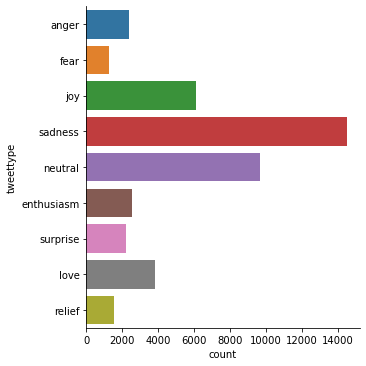

In [30]:
print(tweetData["tweettype"].value_counts())
sb.catplot(y = "tweettype", data = tweetData, kind = "count")

In [ ]:
tweetData.to_csv('combined_tweettypes.csv')